In [69]:
%load_ext autoreload
%autoreload 2

import numpy as np
import seaborn as sns
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import genfromtxt
from mpc.dynamics import AffineDynamics

%matplotlib inline
from controller_utils import sample_initial_signal, episode_loss
from controllers import DDeePC
plt.rcParams["figure.figsize"] = (12,5)
sns.set_theme()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of controller_utils failed: Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    if update_generic(old_obj, new_obj):
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/extension

In [70]:
ud = genfromtxt('recht_ud.csv', delimiter=',')
yd = genfromtxt('recht_yd.csv', delimiter=',')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n = 3 # n = number of states
m = 3 # m = number of inputs
p = 3 # p = number of output
q = m+p # q = number of i/o variables
n_batch = 64
Tini = 4                                   # Past time horizon                                           
Tf = 10                                     # Future time horizon         
T = (m+1)*(Tini + Tf + n) - 1    
noise_std = 0.1              
A = torch.Tensor([[1.01, 0.01, 0.00], # A - State-space matrix
                  [0.01, 1.01, 0.01], 
                  [0.00, 0.01, 1.01]])
dx = AffineDynamics(A=A, B=torch.eye(3)).to(device)
yd += np.random.rand(T,p)*noise_std
u_ini = ud[:Tini,:].reshape((Tini*m,))
y_ini = yd[:Tini,:].reshape((Tini*p,))
y_constraints = np.kron(np.ones(Tf), np.array([10,10,10]))
u_constraints = np.kron(np.ones(Tf), np.array([100,100,100]))

## Initialising Controllers

In [71]:
q = torch.ones(3)*50
r = torch.ones(3)*2
lam_y = torch.Tensor([20])

expert = DDeePC(
    ud=ud, yd=yd, N=Tf, Tini=Tini, T=T, p=3, m=3, n_batch=n_batch,
    y_constraints=y_constraints, u_constraints=u_constraints, device=device,
    stochastic=True, linear=True, q=q, r=r, lam_y=lam_y
).to(device)

controller = DDeePC(
    ud=ud, yd=yd, N=Tf, Tini=Tini, T=T, p=3, m=3, n_batch=n_batch,
    y_constraints=y_constraints, u_constraints=u_constraints, device=device,
    stochastic=True, linear=True, q=q, r=r
).to(device)

for param in controller.parameters():
    print(param)

Parameter containing:
tensor([0.0998], requires_grad=True)


## Training - Run above cell again once training is complete

In [72]:
opt = optim.Rprop(controller.parameters(), lr=0.01, step_sizes=(1e-3,1e2))
pbar = tqdm(range(40), ncols=150)
criterion = torch.nn.HuberLoss()
T = controller.N
I, PI = controller.get_PI()
losses = []
regularizers = []
 
for i, count in enumerate(pbar):
    
    # Get random step response
    ref = torch.Tensor(np.random.uniform(size=(n_batch,p), low=-10.0, high=10.0))
    target_ref = torch.kron(torch.ones(T), ref)
    ref = torch.kron(torch.ones(Tf), ref).to(device)
    ref = torch.zeros(Tf*p).to(device)
    
    # Get random initial condition from data
    u_ini, y_ini = sample_initial_signal(Tini=Tini, m=m, p=p, batch=n_batch, ud=ud, yd=yd)
    u_ini, y_ini = u_ini.to(device), y_ini.to(device)
    uT, yT = u_ini, y_ini

    G, E, Y, U = torch.Tensor(), torch.Tensor(), torch.Tensor(), torch.Tensor()

    for j in range(T):
        # Get optimal action from controller, take MSE of trajectory and reference signal
        noise = torch.randn(y_ini.shape).to(device)*noise_std
        g, u_pred, y_pred, sig_y = controller(ref=ref, u_ini=u_ini, y_ini=y_ini)
        G, E = torch.cat((G, g.unsqueeze(1)), axis=1), torch.cat((E, sig_y.unsqueeze(1)), axis=1) 
        action = u_pred[:,:m]
        U = torch.cat((U, action.unsqueeze(1)), axis=1)
        obs = dx(action, y_ini[:,-p:])
        Y = torch.cat((Y, obs.unsqueeze(1)), axis=1)
        uT = torch.cat((uT, action), 1)
        yT = torch.cat((yT, obs), 1)
        y_ini, u_ini = yT[:,-p*Tini:], uT[:,-m*Tini:]

    # loss = criterion(input=yT[:,p*Tini:], target=target_ref)
    loss = episode_loss(Y=Y, G=G, U=U, E=E, n_batch=n_batch, controller=controller, PI=(I-PI))
    losses.append(loss.item())
    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()
    regularizers.append(controller.lam_y.data.item())
    pbar.set_description(f'Loss = {loss.item():.4f}, lam_y = {controller.lam_y.data.item():.3f}, q = {controller.q.data}, r = {controller.r.data}')

Loss = 340.4178, lam_y = 4.693, q = tensor([50., 50., 50.]), r = tensor([2., 2., 2.]): 100%|██████████████████████████| 40/40 [11:29<00:00, 17.23s/it]


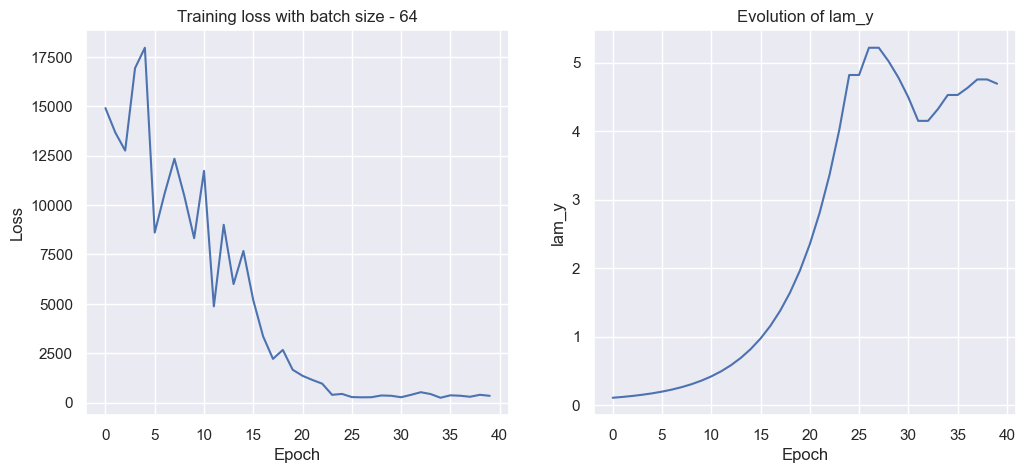

In [74]:
plt.subplot(1,2,1)
plt.plot(range(len(losses)), losses)
plt.grid('on')
plt.title(f'Training loss with batch size - {n_batch}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(range(len(regularizers)), regularizers)
plt.grid('on')
plt.title(f'Evolution of lam_y')
plt.xlabel('Epoch')
plt.ylabel('lam_y')
plt.show()